In [87]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
from PIL import Image
from glob import glob
from hydra import initialize, compose

# set paths to various directories based on the machine this code is being executed on
try:
    with initialize(version_base=None, config_path='config'):
        config = compose(config_name='config.yaml')  # overrides=['machine=uzay']
except:
    with initialize(version_base=None, config_path='../../config'):
        config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.lenses import lens_util
from mejiro.utils import util

In [88]:
pipeline_params = util.hydra_to_dict(config.pipeline)
debugging = pipeline_params['debugging']
debugging = False  # TODO TEMP

if debugging:
    pipeline_dir = f'{config.machine.pipeline_dir}_dev'
else:
    pipeline_dir = config.machine.pipeline_dir

print(f'Pipeline dir: {pipeline_dir}')

Pipeline dir: /data/bwedig/mejiro/pipeline


In [89]:
pipeline_params = util.hydra_to_dict(config.pipeline)
model_stretch = pipeline_params['rgb_stretch']
model_Q = pipeline_params['rgb_q']

In [90]:
color_images, color_model_images, lenses = [], [], []

for index in range(100):
    lens, rgb_model, rgb_image = lens_util.get_sample(pipeline_dir, index, model_stretch=0.05, model_Q=5)
    # if lens.get_einstein_radius() > 0.5 and lens.snr > 50:

    # rgb_image = util.center_crop_image(rgb_image, (45, 45))
    # rgb_model = util.center_crop_image(rgb_model, (45, 45))

    color_images.append(rgb_image)
    color_model_images.append(rgb_model)
    lenses.append(lens)

In [91]:
subfigure_dir = os.path.join(config.machine.data_dir, 'figures', 'mosaic_pieces')
util.create_directory_if_not_exists(subfigure_dir)
util.clear_directory(subfigure_dir)

for idx, (model, image) in enumerate(zip(color_model_images, color_images)):
    f, ax = plt.subplots(1, 2)
    ax[0].imshow(model)
    ax[1].imshow(image)
    for a in ax:
        a.axis('off')
        # a.margins(0,0)
        # a.xaxis.set_major_locator(plt.NullLocator())
        # a.yaxis.set_major_locator(plt.NullLocator())
    # ax[0].autoscale_view('tight')
    # ax[1].autoscale_view('tight')
    plt.subplots_adjust(top=1, bottom=0, right=1, left=0,
                        hspace=0, wspace=0)
    plt.savefig(os.path.join(subfigure_dir, f'{str(idx).zfill(3)}.png'), pad_inches=0)
    plt.close()

In [92]:
mosaic_pieces = [np.array(Image.open(f)) for f in glob(subfigure_dir + '/*.png')]

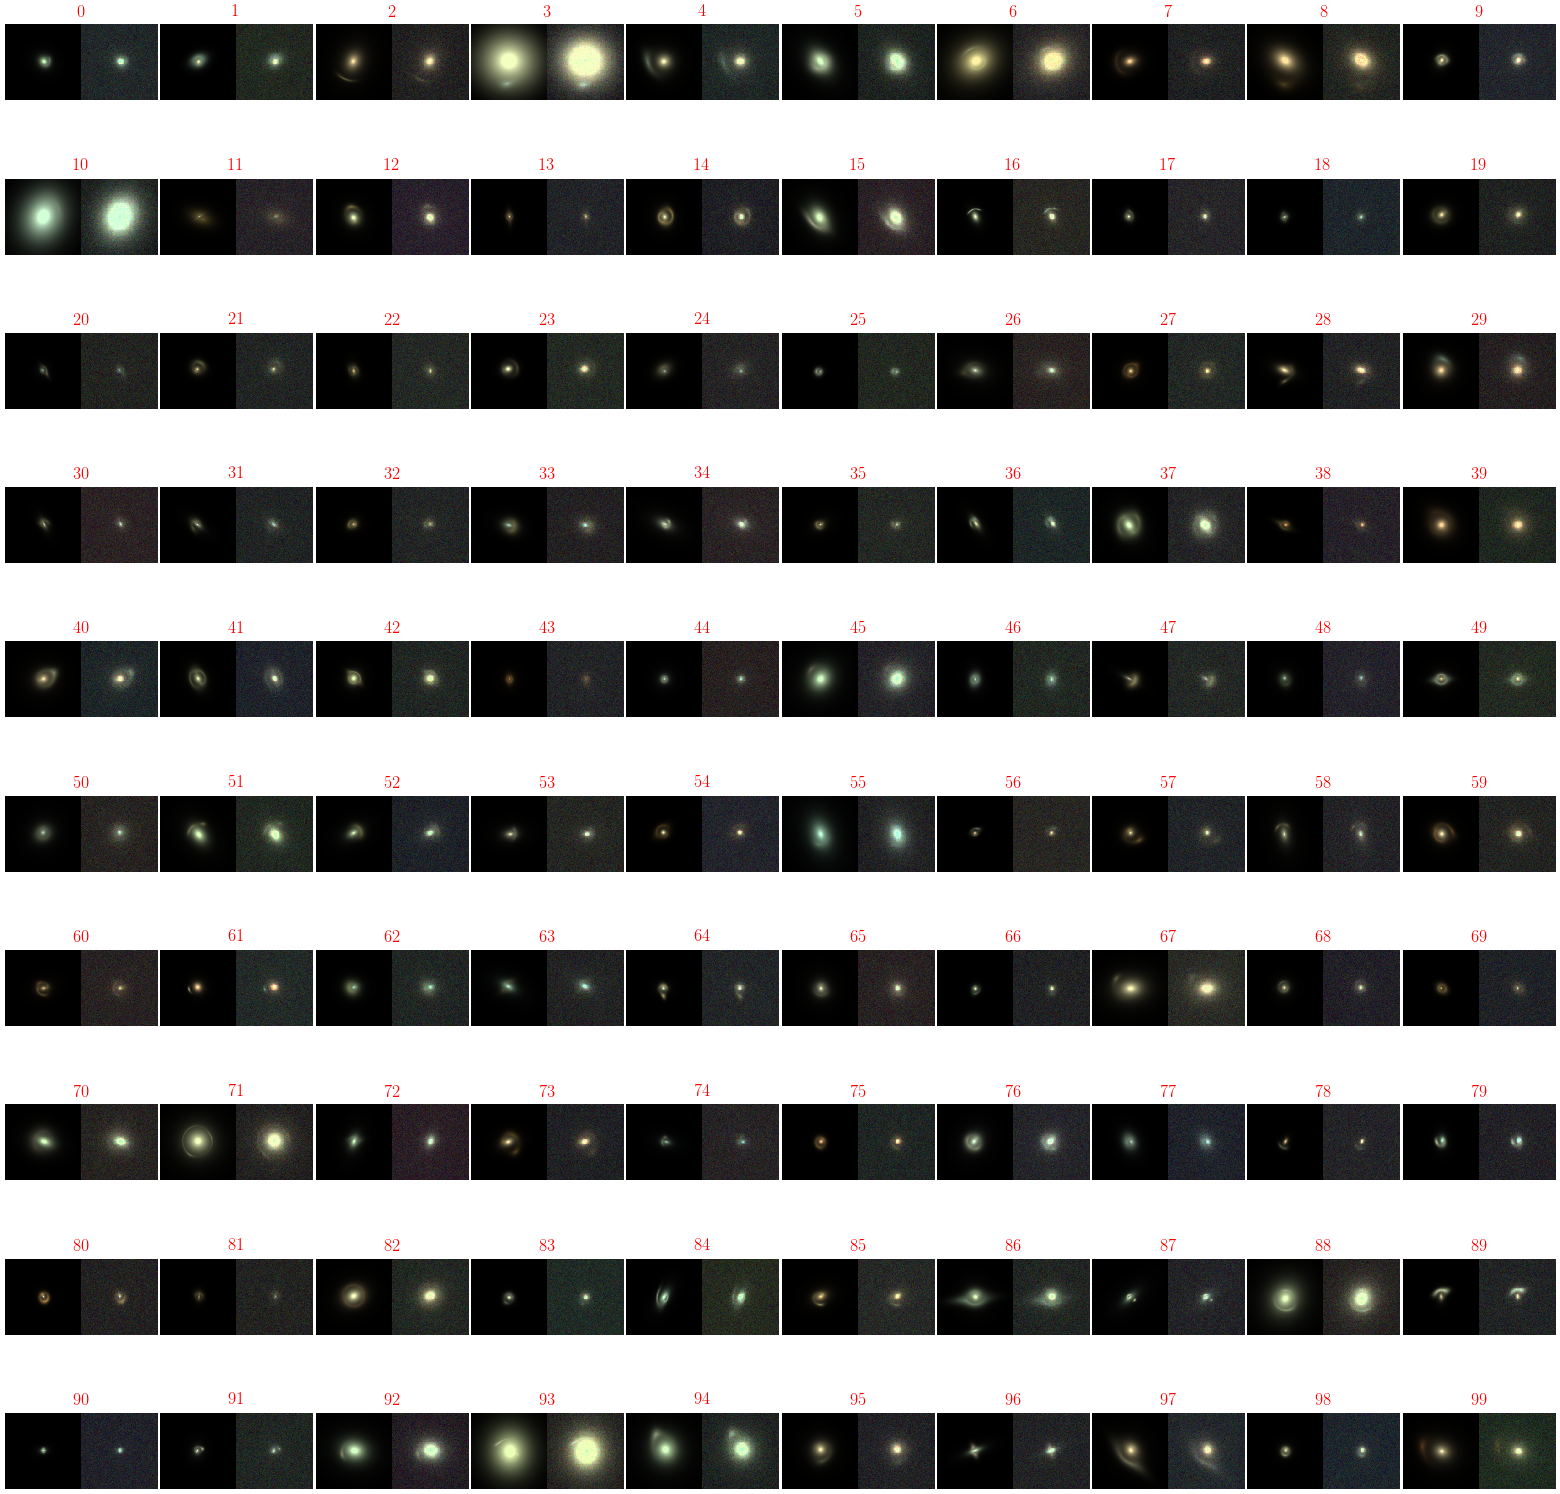

In [93]:
from mejiro.plots import plot

plot.rgb_plot_grid(mosaic_pieces, 10, 10, None)

In [94]:
start_idx = 12
mosaic_subset = mosaic_pieces[start_idx:]

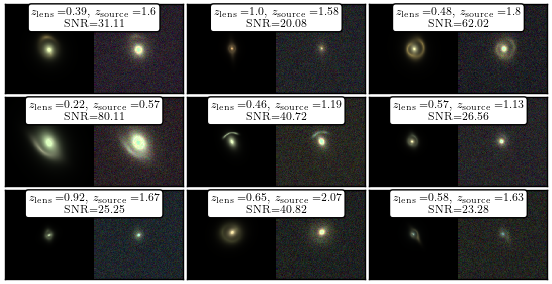

In [95]:
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(7, 4))  # figsize=(14, 14)

grid = ImageGrid(
    fig, 111,
    nrows_ncols=(3, 3),
    axes_pad=0.04,
    label_mode='all',
    share_all=True)

# build captions
text_list = []
for lens in lenses[start_idx:]:
    caption = r'$z_{\textrm{lens}}=$' + str(round(lens.z_lens, 2)) + ', ' + r'$z_{\textrm{source}}=$' + str(
        round(lens.z_source, 2)) + '\n' + f'SNR={lens.snr:.2f}'
    text_list.append(caption)

props = dict(boxstyle='round', facecolor='w')  # , alpha=0.5

for i, ax in enumerate(grid):
    im = ax.imshow(mosaic_subset[i])
    ax.text(0.5, 0.75, text_list[i], transform=ax.transAxes,
            verticalalignment='baseline', ha='center', bbox=props, fontsize=8)

grid.axes_llc.set(xticks=[], yticks=[])

save_path = os.path.join(figure_dir, 'mosaic.png')
plt.savefig(save_path)
plt.show()